In [1]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

from typing import List, Any, Tuple
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
scaler = MinMaxScaler(feature_range=(0,1))

In [3]:
# Define preprocessors
print("Defining preprocessors...")
def column(colnames: List[str]):
    def _column(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [colname, X[colname].values] for colname in colnames
        ]
    return _column

def rangesum(
    name:str, 
    regex: str, 
    prefixes: str, 
    dist: np.ndarray
):
    def _rangesum(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [
                prefix + name, 
                X.filter(regex=(prefix + regex), axis=1).values.dot(dist)
            ] for prefix in prefixes
        ]
    return _rangesum

def _fillna(X: np.ndarray) -> np.ndarray:
    return np.nan_to_num(X, copy=True, nan=0)

def array_divide(
    numerator: List[Tuple[str, np.ndarray]], 
    denominator: List[Tuple[str, np.ndarray]]
) -> List[Any]:
    assert len(numerator) == len(denominator)
    return [
        [
            "r" + numerator_colname, 
            _fillna(np.divide(numerator_col, denominator_col))
        ] for [numerator_colname, numerator_col], [_, denominator_col] in zip(numerator, denominator)
    ]

def one_hot_encode(column: str) -> pd.DataFrame:
    def _one_hot_encode(X: pd.DataFrame):
        X = X.fillna(0)
        df_dummies = pd.get_dummies(X[column], prefix=column)
        return [
            [colname, df_dummies[colname].values] for colname in df_dummies.columns
        ]
    return _one_hot_encode

Defining preprocessors...


In [16]:
def preprocess(X: pd.DataFrame, processors: List[Any]) -> pd.DataFrame:
    X_new = pd.DataFrame()

    for processor in processors:
        for colname, col in processor if type(processor) == type([]) else processor(X):
            X_new[colname] = col

    X_new = X_new.fillna(0)

#     X_new = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

    return X_new

In [5]:
def equal_dist(length: int) -> np.ndarray:
    return np.ones(length)

def linear_dist(length: int) -> np.ndarray:
    return np.arange(start=0, stop=1, step=1/length)

In [6]:
print("Data preprocessing...")
dist_GIT = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_model)
dist_VAT = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_model)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_model)

Data preprocessing...


In [7]:
age_code = np.array(X_model['age_code'])
gender_code = np.array(X_model['gender'])
region_code = np.array(X_model['region_code'])
cat_Featrues = []
cat_Featrues.append(['gender',age_code])
cat_Featrues.append(['age_code',age_code])
cat_Featrues.append(['region_code',region_code])

In [17]:
X_processed = preprocess(
    X_model, 
    [
        cat_Featrues,
        dist_GIT,
        dist_VAT,
        entire,
        # array_divide(dist_GIT, entire), # rel_GIT
        # array_divide(dist_VAT, entire[1:]), # rel_VAT
    ]
)
X_processed.head(3)

,gender,age_code,region_code,cGIT,tGIT,sGIT,tVAT,sVAT,cEntire,tEntire,sEntire
0,13,13,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,93.0
1,5,5,1,2.0,0.0,17.0,0.0,185.0,39.0,0.0,790.0
2,6,6,2,6.0,3.0,2253.0,0.0,1712.0,26.0,3.0,5119.0


In [18]:
#optimize by using optuna
def optimizeLGBM(trial):
    lgbm = LGBMClassifier(
                          task = "train",
                          objective = "binary",
                          categorical_feature = [0,1,2],
                          class_weight={0: 1, 1: 14.291397},
                          metric = "auc",
        
                          n_estimators=trial.suggest_int('n_estimators',100,500),
        
                          # to deal with overfitting, very important param
                          max_depth = trial.suggest_int('max_depth',10,20),
                          learning_rate = trial.suggest_float('learning_rate',0.02,0.1),
                          num_leaves = trial.suggest_int('num_leaves',500,1000),
                          min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100,1000),
        
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = trial.suggest_int('max_bin',255,350),
                          tree_learner = "data",
                          lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
                          lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        
                          # to deal with overfitting
                          min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
                          #for bagging imbalanced
                          bagging_fraction = trial.suggest_float('bagging_fraction', 0,1),
                          pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', 0,1),
                          neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0,1),




    )
    #cross validation K=5
    score = cross_val_score(lgbm, X_processed, Y_model, cv=StratifiedKFold(n_splits=5, shuffle=True),
                            scoring="roc_auc")
    return score.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
LGBM_study = optuna.create_study(direction='maximize')
LGBM_study.optimize(optimizeLGBM, show_progress_bar=True, n_trials=10)

# Print the best parameters
print(LGBM_study.best_params)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=890, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=890
[LightGBM] [Warning] lambda_l1 is set=0.005963070048731841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005963070048731841
[LightGBM] [Warning] bagging_fraction is set=0.48412655589369813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48412655589369813
[LightGBM] [Warning] lambda_l2 is set=0.6883037824242381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6883037824242381
[LightGBM] [Warning] min_data_in_leaf is set=890, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=890
[LightGBM] [Warning] lambda_l1 is set=0.005963070048731841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005963070048731841
[LightGBM] [Warning] bagging_fraction is set=0.48412655589369813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48412655589369813
[LightGBM] [Warning] lambda_l2 is set=0.688303

[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l1 is set=1.0480310455163802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0480310455163802
[LightGBM] [Warning] bagging_fraction is set=0.34381615666833987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34381615666833987
[LightGBM] [Warning] lambda_l2 is set=2.354984081426684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.354984081426684
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l1 is set=1.0480310455163802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0480310455163802
[LightGBM] [Warning] bagging_fraction is set=0.34381615666833987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34381615666833987
[LightGBM] [Warning] lambda_l2 is set=2.354984081426684,

[LightGBM] [Warning] min_data_in_leaf is set=289, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=289
[LightGBM] [Warning] lambda_l1 is set=0.03936657739776251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03936657739776251
[LightGBM] [Warning] bagging_fraction is set=0.8393634721313125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393634721313125
[LightGBM] [Warning] lambda_l2 is set=0.18919968972940812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18919968972940812
[LightGBM] [Warning] min_data_in_leaf is set=289, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=289
[LightGBM] [Warning] lambda_l1 is set=0.03936657739776251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03936657739776251
[LightGBM] [Warning] bagging_fraction is set=0.8393634721313125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393634721313125
[LightGBM] [Warning] lambda_l2 is set=0.189199689729

In [19]:
# apply model and fit
optimized_LGBM = LGBMClassifier(task = "predict",
                          objective = "binary",
                          class_weight={0: 1, 1: 14.291397},
                          metric = "auc",
                          categorical_feature = [0,1,2],
                          n_estimators=LGBM_study.best_params['n_estimators'],
                                
                          # to deal with overfitting, very important param
                          max_depth = LGBM_study.best_params['max_depth'],
                          learning_rate = LGBM_study.best_params['learning_rate'],
                          num_leaves = LGBM_study.best_params['num_leaves'],
                          min_data_in_leaf = LGBM_study.best_params['min_data_in_leaf'],

                          #if max_bin becomes small, the accuracy goes up
                          max_bin = LGBM_study.best_params['max_bin'],
                          tree_learner = "data",
                          lambda_l1 = LGBM_study.best_params['lambda_l1'],
                          lambda_l2 = LGBM_study.best_params['lambda_l2'],
                                
                          # to deal with overfitting
                          min_child_weight = LGBM_study.best_params['min_child_weight'],
                          #for bagging imbalanced
                          bagging_fraction = LGBM_study.best_params['bagging_fraction'],
                          pos_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          neg_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],

                               )


[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

<BarContainer object of 5 artists>

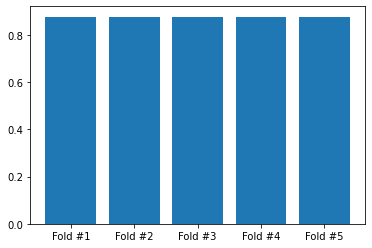

In [20]:
# evaluate
scores = cross_val_score(
    optimized_LGBM, 
    X_processed, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True
                      ),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)

#0.8753111530570191
#0.8756329404995423
#0.8780611462672319 when iterate 10 times
#0.8786665892827801 when iterate 100 times
#0.8786365497775094 -> trial 7 when iterate 10 times

#0.8778765687408898 ???? why?
#0.8778026069580795 when remove outlier
#0.8783678297299062 when remove outlier + class_weight={0: 1, 1: 14.291397}

In [22]:
X_exam = pd.read_csv('X_exam.csv')

In [23]:
print("Data preprocessing...")
dist_GIT_exam = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_exam)
dist_VAT_exam = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_exam)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire_exam = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_exam)

Data preprocessing...


In [26]:
age_code_exam = np.array(X_exam['age_code'])
gender_code_exam = np.array(X_exam['gender'])
region_code_exam = np.array(X_exam['region_code'])
cat_Featrues_exam = []
cat_Featrues_exam.append(['gender',age_code_exam])
cat_Featrues_exam.append(['age_code',age_code_exam])
cat_Featrues_exam.append(['region_code',region_code_exam])

In [27]:
X_exam_processed = preprocess(
    X_exam, 
    [
        cat_Featrues_exam,
        dist_GIT_exam,
        dist_VAT_exam,
        entire_exam
    ]
)

In [28]:
print("Executing...")
Y_exam = np.zeros(X_exam_processed.shape[0])
k = 5
kf = StratifiedKFold(n_splits=k)
for tr_index, val_index in kf.split(X_processed,Y_model):
    X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
    X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]
    
    optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc')
    proba = optimized_LGBM.predict_proba(X_exam_processed)[:,1]
    Y_exam = Y_exam + proba
Y_exam = Y_exam/k
thresholds = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
# the ratio of high prob with different thresholds
for num in thresholds: 
    filtered = Y_exam[np.where(Y_exam>=num)]
    print("the number of probability more than %.2f is %d:" %(num,len(filtered)))
    print("the ratio of probability more than %.2f is : %.4f"%(num, float(len(filtered))/len(Y_exam)))
    print('---------------------------------------------------\n')
    


Executing...
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is s

In [42]:
optimized_LGBM.fit(X_processed,Y_model,eval_metric='auc')
proba = optimized_LGBM.predict_proba(X_exam_processed)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015


In [43]:
final = pd.DataFrame({'business_prob':proba})
P = pd.DataFrame({'popup':np.zeros(X_exam_processed.shape[0],dtype=int)})
S = pd.DataFrame({'survey':np.zeros(X_exam_processed.shape[0],dtype=int)})

final = pd.concat([final,P],axis=1)
final = pd.concat([final,S],axis=1)

In [44]:
final.loc[final['business_prob'] >= 0.5, 'popup'] = int(1)
final.loc[final['business_prob'] >= 0.85, 'survey'] = int(1)
print(final.head())
final.to_csv("./[예선작 중간 제출]데싸왕.csv",index=False)

#  business_prob  popup  survey
# 0       0.426432      0       0
# 1       0.004340      0       0
# 2       0.406342      0       0
# 3       0.005298      0       0
# 4       0.047021      0       0

   business_prob  popup  survey
0       0.426432      0       0
1       0.004340      0       0
2       0.406342      0       0
3       0.005298      0       0
4       0.047021      0       0


In [49]:
final[final['business_prob']>0.5].count()/200000

business_prob    0.328065
popup            0.328065
survey           0.328065
dtype: float64

final[final['business_prob']>0.5].count()/200000

In [36]:
from sklearn.metrics import accuracy_score
Y_exam = np.zeros(X_exam_processed.shape[0])

accuracy_Arr = np.array([])
popup_Arr = np.array([])
survey_Arr = np.array([])

k = 5
kf = StratifiedKFold(n_splits=k)
thresholds = [0.0,0.1,0.4,0.5,0.55,0.6,0.75,0.8,0.85,0.9]
for th in thresholds:
    popup_P = 0
    survey_P = 0
    accuracy = 0
    for tr_index, val_index in kf.split(X_processed,Y_model):
        X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
        X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]

        optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc')
        # Generate the columns
        proba = optimized_LGBM.predict_proba(X_val)[:,1]
        pred = pd.DataFrame({'business prob_pred':proba})
        popup = pd.DataFrame({'popup':np.zeros(X_val.shape[0])})
        survey = pd.DataFrame({'survey':np.zeros(X_val.shape[0])})
        # Merge
        res = pd.concat([pred,popup],axis=1)
        res = pd.concat([res,survey],axis=1)
        
        # If predicted proba is more than th, put his popup as 1
        res.loc[res['business prob_pred'] >= th, 'popup'] = 1
        res.loc[res['business prob_pred'] >= th, 'survey'] = 1
        
        accuracy += accuracy_score(Y_val, res['popup'])
        res = pd.concat([res,Y_val.reset_index(drop=True)],axis=1) # Merge res with Y_val
        popup_P += res.loc[res['popup']==1,'business'].sum()*(500000*0.01) - res['popup'].sum()*400
        survey_P += res.loc[res['survey']==1,'business'].sum()*(500000*0.036) - res['survey'].sum()*5000
        
    accuracy_Arr = np.append(accuracy_Arr,accuracy/k)
    popup_Arr = np.append(popup_Arr,popup_P/k)
    survey_Arr = np.append(survey_Arr,survey_P/k)


[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.0010487932251925015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010487932251925015
[LightGBM] [Warning] min_data_in_leaf is set=957, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=957
[LightGBM] [Warning] lambda_l1 is set=0.4983522855323571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4983522855323571
[LightGBM] [Warning] bagging_fraction is set=0.23064559319476596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23064559319476596
[LightGBM] [Warning] lambda_l2 is set=0.00104879

In [38]:
df = pd.DataFrame({'threshold':thresholds, 'avg_Accuracy':accuracy_Arr, 'avg_Popup_Profit':popup_Arr, 'avg_Survey_Porfit':survey_Arr})
print(df)

   threshold  avg_Accuracy  avg_Popup_Profit  avg_Survey_Porfit
0       0.00      0.065396       -11683000.0       -611658800.0
1       0.10      0.572831        20518160.0       -206234000.0
2       0.40      0.686539        25781960.0       -119103200.0
3       0.50      0.724443        26526120.0        -91983400.0
4       0.55      0.744105        26555600.0        -78594200.0
5       0.60      0.766118        26240720.0        -64267400.0
6       0.75      0.879353        18064520.0         -3057000.0
7       0.80      0.914630        12564040.0         10387400.0
8       0.85      0.929557         8463440.0         12699000.0
9       0.90      0.935150         4971640.0          9840200.0
